# comparing ZTF CLAGN to other AGNs
start date: Feb 6th, 2023, Last edit: June 13

In [1]:
!pip install -r requirements.txt

import numpy as np
import time
import pandas as pd
#import axs
import os
import sys
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import requests
import pickle

from scipy import stats

from astroquery.ipac.ned import Ned
from astroquery.heasarc import Heasarc
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord, name_resolve
import astropy.units as u
from astropy.table import Table, vstack, hstack, unique
from astropy.io import fits,ascii
from astropy.time import Time
from astropy.timeseries import TimeSeries


try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try:
    import lightkurve as lk
except ImportError:
    !pip install lightkurve --upgrade
    import lightkurve as lk
        
try:
    from acstools import acszpt
except ImportError:
    !pip install acstools
    from acstools import acszpt

import warnings
warnings.filterwarnings('ignore')

#try:
#    from unTimely_Catalog_tools import unTimelyCatalogExplorer
#except ImportError:
#    if not os.path.exists('./unTimely_Catalog_explorer'):
#        !git clone https://github.com/fkiwy/unTimely_Catalog_explorer.git
#    sys.path.append('./unTimely_Catalog_explorer')
#    from unTimely_Catalog_tools import unTimelyCatalogExplorer
    
import tempfile

## for ZTF query by name
try:
    from alerce.core import Alerce
except ImportError:
    !pip install alerce
    from alerce.core import Alerce

try:
    import umap
    import umap.plot

except:
    !pip install umap-learn[plot]

# Local code imports
sys.path.append('code/')
from fluxconversions import convert_WISEtoJanskies, convertACSmagtoflux
from panstarrs import ps1cone, ps1search, checklegal, ps1metadata, addfilter, improve_filter_format, search_lightcurve
from gaia_functions import Gaia_retrieve_EPOCH_PHOTOMETRY, Gaia_mk_lightcurves, Gaia_mk_MultiIndex
from HCV_functions import get_hscapiurl, hcvcone, hcvsearch, hcvmetadata, cat2url, checklegal_hcv
from mast_functions import resolve, mastQuery
from icecube_functions import icecube_get_catalog
from sample_selection import get_lamassa_sample, get_macleod16_sample, get_ruan_sample, get_macleod19_sample, get_sheng_sample, \
    get_green_sample, get_lyu_sample, get_lopeznavas_sample, get_hon_sample, get_yang_sample,get_SDSS_sample, get_paper_sample, clean_sample
from ztf_functions import ZTF_id2coord,ZTF_get_lightcurve

from tqdm import tqdm

# Defined metric to be used by umap. DTW is appropriate for time series distance

import numba

def unify_lc(df_lc,bands_inlc=['zr','zi','zg',],xres=160,numplots=1):
    x_ztf = np.linspace(0,1600,xres) # X array for interpolation
    x_wise = np.linspace(0,4000,int(xres*2)) # X array for interpolation

    printcounter = 0
    objects,dobjects,flabels = [],[],[]

    for obj in tqdm(df_lc.data.count(axis=0,level=0).index):

        singleobj = df_lc.data.loc[obj,:,:,:]    
        label = singleobj.index.unique('label')
        bands = singleobj.loc[obj,label[0],:,:].index.get_level_values('band')[:].unique()
        if len(np.intersect1d(bands,bands_inlc))==len(bands_inlc):
            if printcounter<numplots:
                fig= plt.subplots(figsize=(15,5))
                    
            obj_newy = [ [] for _ in range(len(bands_inlc))]
            obj_newdy = [ [] for _ in range(len(bands_inlc))]

            keepobj = 1 # 
            for l,band in enumerate(bands_inlc):
                band_lc = singleobj.loc[obj,label[0], band, :]
                band_lc_clean = band_lc[band_lc.index.get_level_values('time') < 65000]
                x,y,dy = np.array(band_lc_clean.index.get_level_values('time')-band_lc_clean.index.get_level_values('time')[0]),np.array(band_lc_clean.flux),np.array(band_lc_clean.err)

                x2,y2,dy2 = x[np.argsort(x)],y[np.argsort(x)],dy[np.argsort(x)]
                if len(x2)>5:
                    n = np.sum(x2==0)
                    for b in range(1,n): # this is a hack of shifting time of different lightcurves by a bit so I can interpolate! 
                        x2[::b+1]=x2[::b+1]+1*0.001 
                
                    f = interpolate.interp1d(x2,y2,kind='previous',fill_value="extrapolate")
                    df = interpolate.interp1d(x2,dy2,kind='previous',fill_value="extrapolate")
                    
                    if printcounter<numplots:    
                        plt.errorbar(x2,y2,dy2 , capsize = 1.0,marker='.',linestyle='', label = label[0]+band)
                        if band=='w1' or band=='w2':
                            plt.plot(x_wise,f(x_wise),'--',label='nearest interpolation '+str(band))
                        else:
                            plt.plot(x_ztf,f(x_ztf),'--',label='nearest interpolation '+str(band))
                
                    if band =='w1' or band=='w2':
                        obj_newy[l] = f(x_wise)#/f(x_wise).max()
                        obj_newdy[l] = df(x_wise)
                    else:
                        obj_newy[l] = f(x_ztf)#/f(x_ztf).max()
                        obj_newdy[l] = df(x_ztf)#/f(x_ztf).max()
                        
                if len(obj_newy[l])<5: #don't keep objects which have less than x datapoints in any keeoping bands
                    keepobj = 0         
            
            if printcounter<numplots:
                plt.title('Object '+str(obj)+' from '+label[0]+' et al.')
                plt.xlabel('Time(MJD)')
                plt.ylabel('Flux(mJy)')
                plt.legend()
                plt.show()
                printcounter+=1


        if keepobj:
            objects.append(obj_newy)
            dobjects.append(obj_newdy)
            flabels.append(label[0])
    return np.array(objects),np.array(dobjects),flabels

def combine_bands(objects,bands):
    '''
    combine all lightcurves in individual bands of an object
    into one long array, by appending the indecies.
    '''
    dat = []
    for o,ob in enumerate(objects):
        obj = []
        for b in range(len(bands)):
            obj = np.append(obj,ob[b],axis=0)
        dat.append(obj)
    return np.array(dat)

def mean_fractional_variation(lc,dlc):
    '''A common way of defining variability'''
    meanf = np.mean(lc) #mean flux of all points
    varf = np.std(lc)**2
    deltaf = np.mean(dlc)**2 
    fvar = (np.sqrt(varf-deltaf))/meanf
    return fvar

def stat_bands(objects,dobjects,bands):
    '''
    returns arrays with maximum,mean,std flux in lightcurves of each band .
    '''
    fvar,maxarray,meanarray = np.zeros((len(bands),len(objects))),np.zeros((len(bands),len(objects))),np.zeros((len(bands),len(objects)))
    for o,ob in enumerate(objects):
        for b in range(len(bands)):
            maxarray[b,o] = ob[b].max()
            meanarray[b,o] = ob[b].mean()
            fvar[b,o] = mean_fractional_variation(ob[b],dobjects[o,b,:])
    return fvar,maxarray,meanarray


def normalize_objects(data):
    '''
    normalize objects in all bands together.
    '''
    # normalize each databand
    row_sums = data.max(axis=1)
    return data / row_sums[:, np.newaxis]

# Shuffle before feeding to umap
def shuffle_datalabel(data,labels):
    """shuffles the data, labels and also returns the indecies """
    p = np.random.permutation(len(data))
    data2 = data[p,:]
    fzr=np.array(labels)[p.astype(int)]
    return data2,fzr,p

@numba.njit()
def dtw_distance(series1, series2):
    """
    Returns the DTW similarity distance between two 2-D
    timeseries numpy arrays.
    Arguments:
        series1, series2 : array of shape [n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
    Returns:
        DTW distance between sequence 1 and 2
    """
    l1 = series1.shape[0]
    l2 = series2.shape[0]
    E = np.empty((l1, l2))

    # Fill First Cell
    E[0][0] = np.square(series1[0] - series2[0])

    # Fill First Column
    for i in range(1, l1):
        E[i][0] = E[i - 1][0] + np.square(series1[i] - series2[0])

    # Fill First Row
    for i in range(1, l2):
        E[0][i] = E[0][i - 1] + np.square(series1[0] - series2[i])

    for i in range(1, l1):
        for j in range(1, l2):
            v = np.square(series1[i] - series2[j])

            v1 = E[i - 1][j]
            v2 = E[i - 1][j - 1]
            v3 = E[i][j - 1]

            if v1 <= v2 and v1 <= v3:
                E[i][j] = v1 + v
            elif v2 <= v1 and v2 <= v3:
                E[i][j] = v2 + v
            else:
                E[i][j] = v3 + v

    return np.sqrt(E[-1][-1])
from scipy import interpolate

## MultiIndex Pandas data frame object in which we can append the light curves:
class MultiIndexDFObject:
    '''
    Pandas data frame MultiIndex object. 
    - add(): append new MultiIndex light curve data frame.
    - .data returns the data.
    '''
    def __init__(self):
        pass
    
    def append(self,x):
        try:
            self.data
        except AttributeError:
            self.data = x.copy()
        else:
            self.data = pd.concat([self.data , x])
            
    def pickle(self,x):
        self.data.to_pickle(x)  
        
    def load_pickle(self,x):
        with open(x , "rb") as f:
            self.data = pickle.load(f)
            
    def remove(self,x):
        self.data.drop(x,inplace=True)
        self.data.reset_index()

plt.style.use('bmh')

try:
    import pickle5 as pickle
except:
    !pip3 install pickle5
    import pickle5 as pickle


  Cloning https://github.com/fkiwy/unTimely_Catalog_explorer to /tmp/pip-req-build-1zo1jzca
  Running command git clone --filter=blob:none --quiet https://github.com/fkiwy/unTimely_Catalog_explorer /tmp/pip-req-build-1zo1jzca
  Resolved https://github.com/fkiwy/unTimely_Catalog_explorer to commit 954b06b5dc91c207c335e652083327c4ec136dd9
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


# Sample:

In [2]:
#build up the sample
coords =[]
labels = []

#choose your own adventure:
get_lamassa_sample(coords, labels)  #2015ApJ...800..144L
get_macleod16_sample(coords, labels) #2016MNRAS.457..389M
get_ruan_sample(coords, labels) #2016ApJ...826..188R
get_macleod19_sample(coords, labels)  #2019ApJ...874....8M
get_sheng_sample(coords, labels)  #2020ApJ...889...46S
get_green_sample(coords, labels)  #2022ApJ...933..180G
get_lyu_sample(coords, labels)  #z32022ApJ...927..227L
get_lopeznavas_sample(coords, labels)  #2022MNRAS.513L..57L
get_hon_sample(coords, labels)  #2022MNRAS.511...54H
get_yang_sample(coords, labels)   #2018ApJ...862..109Y

# Variable AGN sample from Ranga/Andreas:
VAGN = pd.read_csv('data/WISE_MIR_variable_AGN_with_PS1_photometry_and_SDSS_redshift.csv')
vagn_coords = [SkyCoord(ra, dec, frame='icrs', unit='deg') for ra, dec in zip(VAGN['SDSS_RA'], VAGN['SDSS_Dec'])]
vagn_labels = ['WISE-Variable' for ra in VAGN['SDSS_RA']]
coords.extend(vagn_coords)
labels.extend(vagn_labels)    
print('Variable AGN- Ranga/Andreas et al: ',len(vagn_coords))

#now get some "normal" QSOs for use in the classifier
#there are ~500K of these, so choose the number based on
#a balance between speed of running the light curves and whatever 
#the ML algorithms would like to have
num_normal_QSO = 605 
get_SDSS_sample(coords, labels, num_normal_QSO)


## ADD TDEs to the sample, manually copied the TDE ZTF names from Hammerstein et al. 2023
tde_names = ['ZTF18aabtxvd','ZTF18aahqkbt','ZTF18abxftqm','ZTF18acaqdaa','ZTF18acpdvos','ZTF18actaqdw','ZTF19aabbnzo',
             'ZTF18acnbpmd','ZTF19aakiwze','ZTF19aakswrb','ZTF17aaazdba','ZTF19aapreis','ZTF19aarioci','ZTF19abhejal',
             'ZTF19abhhjcc','ZTF19abidbya','ZTF19abzrhgq','ZTF19accmaxo','ZTF20aabqihu','ZTF19acspeuw','ZTF20aamqmfk',
             'ZTF18aakelin','ZTF20abjwvae','ZTF20abfcszi','ZTF20abefeab','ZTF20abowque','ZTF20abrnwfc','ZTF20acitpfz',
             'ZTF20acqoiyt', 'ZTF20abnorit']

ZTF_id2coord(tde_names,coords,labels)

get_paper_sample('2019A&A...627A..33D','Cicco19',coords,labels)
get_paper_sample('2022ApJ...933...37W','Galex variable 22',coords,labels)
get_paper_sample('2020ApJ...896...10B','Palomar variable 20',coords,labels)


#remove duplicates from the list if combining multiple references
coords_list, labels_list = clean_sample(coords, labels)
print('final sample: ',len(coords_list))


Changing Look AGN- Lamassa et al:  1
Changing Look AGN- MacLeod et al 2016:  10
Changing Look AGN- Ruan et al 2016:  3
Changing Look AGN- MacLeod et al 2017:  17
Changing Look AGN- Sheng et al 2020:  3
Changing Look AGN- Green et al 2022:  19
Changing Look AGN- Lyu et al 2021:  68
Changing Look AGN- Lopez-navas et al 2022:  4
Changing Look AGN- Hon et al 2022:  29
Changing Look AGN- Yang et al:  31
Variable AGN- Ranga/Andreas et al:  767
SDSS Quasar: 605
number of ztf coords added by Objectname: 10
number of sources added from Cicco19 :299
number of sources added from Galex variable 22 :48
number of sources added from Palomar variable 20 :20
after duplicates removal, sample size: 1878
final sample:  1878


# Read in ZTF Light curves (takes long- skip if already have a pickled file)

In [3]:
#df_lc = MultiIndexDFObject()
#df_lc = ZTF_get_lightcurve(coords_list,labels_list,plotprint=2) ## number of plots to show to be set by plotprint

# to avoid running this for an hour again
#df_lc.pickle("data/large.pkl")

# Plot and unify grid

  0%|          | 0/1715 [00:00<?, ?it/s]

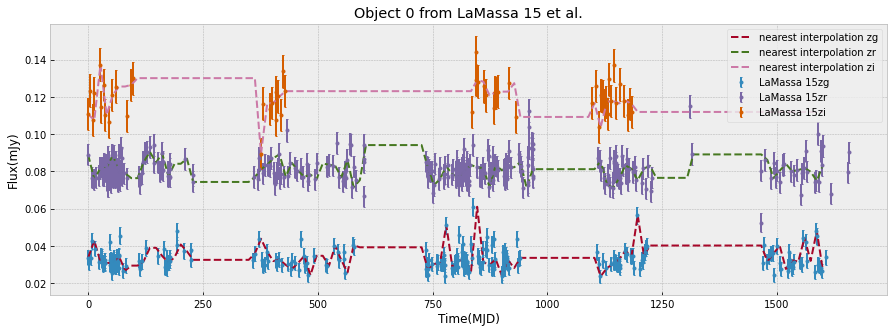

  0%|          | 1/1715 [00:00<15:20,  1.86it/s]

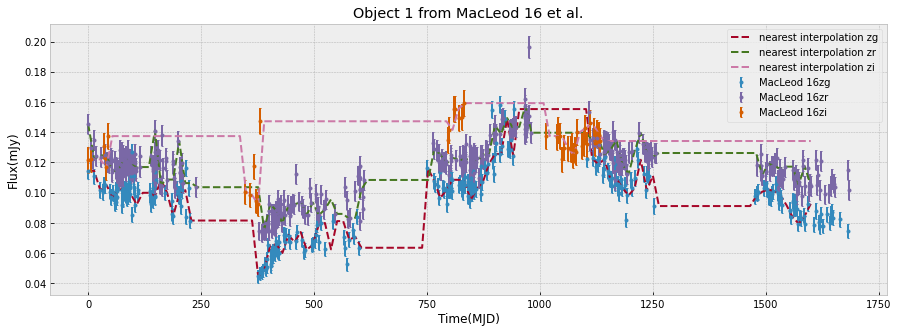

  0%|          | 2/1715 [00:01<17:15,  1.65it/s]

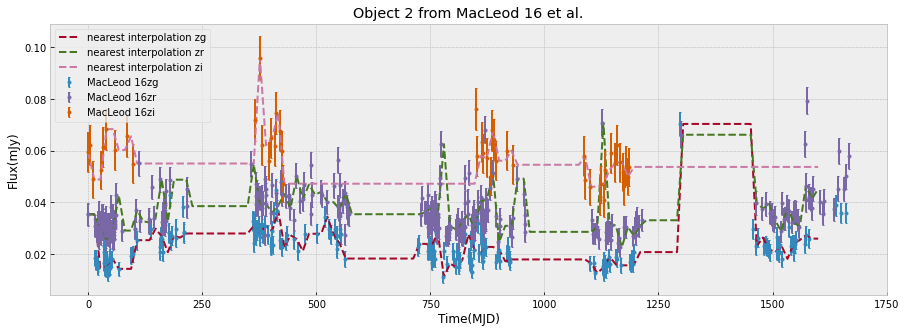

  0%|          | 3/1715 [00:01<15:58,  1.79it/s]

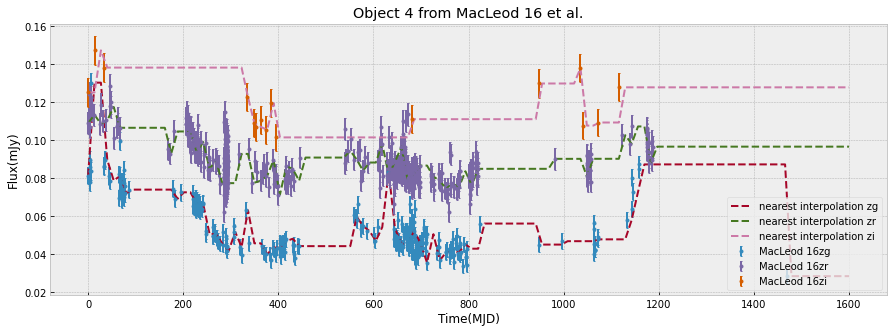

  0%|          | 5/1715 [00:02<13:19,  2.14it/s]

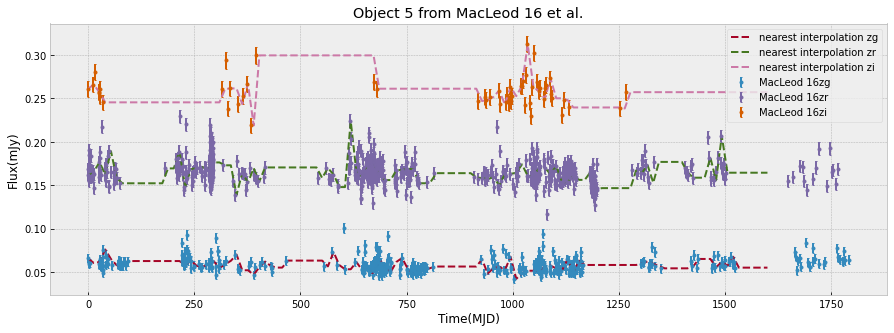

100%|██████████| 1715/1715 [00:40<00:00, 42.09it/s]


In [4]:
df_lc = MultiIndexDFObject()
#df_lc.load_pickle("data/dflc_changinglook_ZTF_1.5.pkl") ## has all only in ztf
df_lc.load_pickle("data/large.pkl") ## only cicco
bands_inlc = ['zg','zr','zi']

objects,dobjects,flabels = unify_lc(df_lc,bands_inlc,xres=120,numplots=5)
dat = combine_bands(objects,bands_inlc)
fvar, maxarray,meanarray = stat_bands(objects,dobjects,bands_inlc)
#dat = normalize_objects(dat)
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]

    

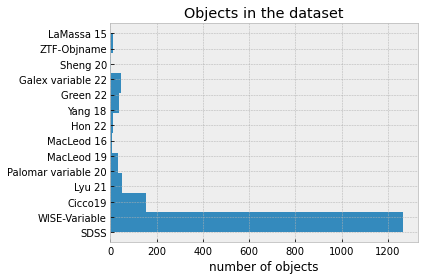

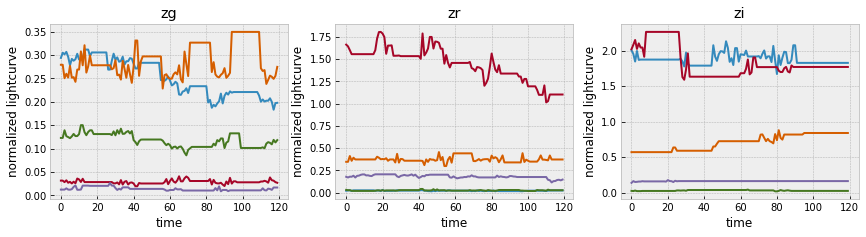

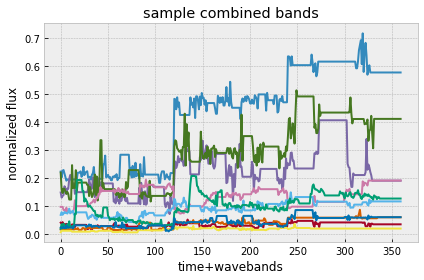

In [5]:
plt.figure(figsize=(6,4))
plt.title("Objects in the dataset")
h = plt.hist(fzr,histtype='stepfilled',orientation='horizontal')
plt.xlabel('number of objects')
plt.tight_layout()

plt.figure(figsize=(16,12))
for b,band in enumerate(bands_inlc):
    for ii in range(5):
        i = np.random.randint(len(objects))
        plt.subplot(4,4,b+1)
        plt.title(band)
        if band=='w1' or band=='w2':
            plt.plot(objects[i,b],label=band)
            plt.xlabel('time')
            plt.ylabel('normalized lightcurve')
        else:
            #print(objects[i,b])
            plt.plot(objects[i,b],label=band)
            plt.xlabel('time')
            plt.ylabel('normalized lightcurve')
plt.tight_layout()

plt.figure(figsize=(6,4))
plt.title("sample combined bands")
for i in range(10):
    ii = np.random.randint(len(data))
    plt.plot(data[ii])
plt.xlabel('time+wavebands')
plt.ylabel('normalized flux')
plt.tight_layout()

# UMAP exploration

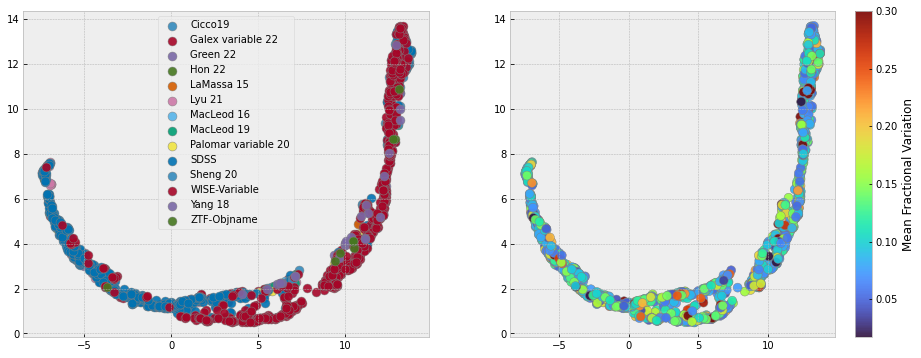

In [47]:
plt.figure(figsize=(16,6))
mapper = umap.UMAP(n_neighbors=200,min_dist=0.1,metric='manhattan',random_state=50).fit(data)
fvar_all = np.nansum(fvar,axis=0)/np.sum(np.isfinite(fvar),axis=0) ## adding the fractional variation in all bands accounting for Nans
fvar_all[fvar_all>0.3]=0.3 ## to see the dynamic range better, a cap on values
plt.subplot(1,2,2)
plt.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],c=fvar_all,s=80,alpha=0.9,edgecolor='gray',cmap='turbo')
cbar = plt.colorbar()
cbar.set_label('Mean Fractional Variation') ## defined in flux I did in magnitude


plt.subplot(1,2,1)
for lab in np.unique(fzr):
    u=(fzr[:]==lab)
    plt.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=80,alpha=0.9,edgecolor='gray',label=lab)
plt.legend()

In [ ]:
hover_data = pd.DataFrame({'index':np.arange(len(data)), 'label':fzr,'max-g(umj)':maximum_arr[0,:],'max-r(umj)':maximum_arr[1,:],'max-i(umj)':maximum_arr[2,:]})
mapper = umap.UMAP(n_neighbors=50,min_dist=0.2,metric=dtw_distance,random_state=1).fit(data)
plt.figure(figsize=(12,10))
for lab in np.unique(fzr):
    u=(fzr[:]==lab)
    plt.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=80,alpha=0.9,edgecolor='gray',label=lab)
plt.legend()

In [ ]:
mapper = umap.UMAP(n_neighbors=200,min_dist=0.9,metric=dtw_distance,random_state=10).fit(data)
umap.plot.connectivity(mapper, show_points=False,width=800,height=500)

In [ ]:
markersize=100

for n in (2, 5, 10, 20, 50, 100, 200,500):
    
    mapperg = umap.UMAP(n_neighbors=n,min_dist=0.5,metric='manhattan',random_state=20).fit(data)
    plt.figure(figsize=(9,6))
    for lab in np.unique(fzr):
        ax0 = plt.subplot(1,1,1)
        ax0.set_title('UMAP metric : Manhattan, n_neighbors='+str(n)+' min_dist=0.05',size=15)
        u=(fzr[:]==lab)
        if lab=='ZTF-Objname':
            cf = ax0.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=markersize,alpha=0.9,edgecolor='gray',label='TDE')
        else:
            cf = ax0.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=markersize,alpha=0.9,edgecolor='gray',label=lab)
    plt.legend()
    #ax0.axis('off')
    plt.tight_layout()


In [ ]:
markersize=100

for dist in (0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1):
    n = 300
    mapperg = umap.UMAP(n_neighbors=n,min_dist=dist,metric='manhattan',random_state=20).fit(data)
    plt.figure(figsize=(9,6))
    for lab in np.unique(fzr):
        ax0 = plt.subplot(1,1,1)
        ax0.set_title('UMAP metric : Manhattan, n_neighbors='+str(n)+' min_dist='+str(dist),size=15)
        u=(fzr[:]==lab)
        if lab=='ZTF-Objname':
            cf = ax0.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=markersize,alpha=0.9,edgecolor='gray',label='TDE')
        else:
            cf = ax0.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=markersize,alpha=0.9,edgecolor='gray',label=lab)
    plt.legend()
    #ax0.axis('off')
    plt.tight_layout()


In [ ]:
markersize=100
metric_names = ["dtw","euclidean","manhattan","cosine","correlation","wminkowski"]
metrics = [dtw_distance,"euclidean","manhattan","cosine","correlation","wminkowski"]

for i,m in enumerate(metrics):
    n = 200
    dist = 0.5
    mapperg = umap.UMAP(n_neighbors=n,min_dist=dist,metric=m,random_state=12).fit(data)
    plt.figure(figsize=(9,6))
    for lab in np.unique(fzr):
        ax0 = plt.subplot(1,1,1)
        ax0.set_title('UMAP metric :'+metric_names[i]+', n_neighbors='+str(n)+' min_dist='+str(dist),size=15)
        u=(fzr[:]==lab)
        if lab=='ZTF-Objname':
            cf = ax0.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=markersize,alpha=0.9,edgecolor='gray',label='TDE')
        else:
            cf = ax0.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=markersize,alpha=0.9,edgecolor='gray',label=lab)
    plt.legend()
    #ax0.axis('off')
    plt.tight_layout()


# Separate bands

In [ ]:
mapperg = umap.UMAP(n_neighbors=100,min_dist=0.8,metric='euclidean',random_state=20).fit(objects[:,0])
mapperr = umap.UMAP(n_neighbors=100,min_dist=0.8,metric='euclidean',random_state=20).fit(objects[:,1])
mapperi = umap.UMAP(n_neighbors=100,min_dist=0.8,metric='euclidean',random_state=20).fit(objects[:,2])

xmin,xmax = np.min(mapperr.embedding_[:,0])-0.2,np.max(mapperr.embedding_[:,0])+0.2
ymin,ymax = np.min(mapperr.embedding_[:,1])-0.2,np.max(mapperr.embedding_[:,1])+0.2
plt.figure(figsize=(9,6))
markersize=100
ax0 = plt.subplot(1,1,1)
#plt.style.use('dark_background')
cf = ax0.scatter(mapperg.embedding_[:,0],mapperg.embedding_[:,1],c='g',s=markersize,alpha=0.7,edgecolor='gray',marker='s',cmap='inferno',label='zg')
cf = ax0.scatter(mapperr.embedding_[:,0],mapperr.embedding_[:,1],c='r',s=markersize,alpha=0.7,edgecolor='gray',marker='s',cmap='inferno',label='zr')
cf = ax0.scatter(mapperi.embedding_[:,0],mapperi.embedding_[:,1],c='b',s=markersize,alpha=0.7,edgecolor='gray',marker='s',cmap='inferno',label='zi')

ax0.text(xmin+0.1,ymax-0.1,'UMAP metric : euclidean, n_neighbors=7, min_dist=0.01',size=15)
#cbar = plt.colorbar(cf, ticks=[1, 2, 3,4,5,6])
#cbar.ax.set_yticklabels(pd.unique(labels))
#ax0.set_xlim([xmin,xmax])
#ax0.set_ylim([ymin,ymax])
plt.legend()
ax0.axis('off')
plt.tight_layout()


# Explore as 2D images:

In [ ]:
for i in range(50):
    plt.figure(figsize=(15,15))
    plt.imshow(objects[i]/objects[i].max(), aspect=10, interpolation='hamming')
    plt.ylim([0,2])
    ylabels=['g','r','i']
    plt.yticks(ticks=[0,1,2],labels=ylabels)

In [ ]:
df_lc = MultiIndexDFObject()
df_lc.load_pickle("data/dflc_1000_ZTF.pkl")

from scipy import interpolate
x_new = np.linspace(0,1600,160) # X array for interpolation

plotprint,printcounter = 1,0
objects,flabels = [],[]

for obj in tqdm(df_lc.data.count(axis=0,level=0).index):

    singleobj = df_lc.data.loc[obj,:,:,:]    
    label = singleobj.index.unique('label')
    bands = singleobj.loc[obj,label[0],:,:].index.get_level_values('band')[:].unique()
    if len(bands)>=3 :
        if plotprint:
            fig= plt.subplots(figsize=(15,5))
                    
        obj_newy = [[],[],[]]    

        for l,band in enumerate(bands):
            band_lc = singleobj.loc[obj,label[0], band, :]
            band_lc_clean = band_lc[band_lc.index.get_level_values('time') < 65000]
            x,y,dy = np.array(band_lc_clean.index.get_level_values('time')-band_lc_clean.index.get_level_values('time')[0]),np.array(band_lc_clean.flux),np.array(band_lc_clean.err)

            x2,y2,dy2 = x[np.argsort(x)],y[np.argsort(x)],dy[np.argsort(x)]
            if len(x2)>10:
                n = np.sum(x2==0)
                for b in range(1,n): # this is a hack of shifting time of different lightcurves by a bit so I can interpolate! 
                    x2[::b+1]=x2[::b+1]+1*0.001 
                
                f = interpolate.interp1d(x2,y2,kind='previous',fill_value="extrapolate")
                if plotprint:    
                    plt.errorbar(x2,y2,dy2 , capsize = 1.0,marker='.',linestyle='', label = label[0])
                    plt.plot(x_new,f(x_new),'--',label='nearest interpolation '+str(band))
                obj_newy[l] = f(x_new)
                    
            
        if plotprint:
            plt.title('Object '+str(obj)+' from '+label[0]+' et al.')
            plt.xlabel('Time(MJD)')
            plt.ylabel('Flux(mJy)')
            plt.legend()
            plt.show()
            printcounter+=1
            if printcounter>0:
                plotprint=0
    if (len(obj_newy[0])>2) and (len(obj_newy[1])>2) and (len(obj_newy[2])>2):
        objects.append(obj_newy)
        flabels.append(label[0])
    

In [ ]:
objects = np.array(objects)
gr = objects[:,0,:]/ objects[:,0,:].max(axis=0)
rr = objects[:,1,:]/ objects[:,1,:].max(axis=0)
ir = objects[:,2,:]/ objects[:,2,:].max(axis=0)

# Shuffle before feeding to umap
p = np.random.permutation(len(gr))
data = np.concatenate((gr[p,:],rr[p,:],ir[p,:]),axis=1)
fzr=np.array(flabels)[p.astype(int)]
print(np.shape(fzr),np.shape(data))

In [ ]:
mapperg = umap.UMAP(n_neighbors=200,min_dist=1.0,metric='manhattan',random_state=24).fit(data)
plt.figure(figsize=(9,6))
for lab in np.unique(fzr):
    ax0 = plt.subplot(1,1,1)
    ax0.set_title('UMAP metric : Manhattan, n_neighbors=200, min_dist=1.0',size=15)
    u=(fzr[:]==lab)
    if lab=='ZTF-Objname':
        cf = ax0.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=20,c='black',alpha=0.9,edgecolor='gray',label='TDE')
    else:
        cf = ax0.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=20,alpha=0.9,edgecolor='gray',label=lab)
plt.legend()
plt.tight_layout()
